# Global definitions

Load Pylab, define CPTs...  
**Topological order: LPBTO**  

In [96]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [125]:
# Define the CPTs and other useful functions here (e.g. samling from a distribution) here...
POB = array([[[0.01, 0.7], 
               [0.99, 0.3] ],
            [[0.8, 0.999],
            [0.2, 0.001]]])
O_PB = POB.transpose(1, 0, 2)
T_P = array([[0.8, 0.1],
             [0.2, 0.9]])
P_L = T_P.copy()  #copy array and not reference 
L = array([0.9, 0.1])
B = array([0.99, 0.01])

def randomPos(X):
    return X.cumsum().searchsorted(random.sample(1))[0]

def normalization(x, y):
    if y == 0.0: 
        return array([NaN, NaN]) #suggestion from T.A.
    else:
        return array([x / float(y), 1 - x / float(y)])

def normalVec2(X):
    return normalization(X[0], X[0] + X[1])

def ranPos2(X, x):
    if x > X[0]:
        return 1
    else:
        return 0

    

# 1) Approximate Inference Algorithms

Approximate $P(E\mid M, S)$ using various techniques.  
Query: $P(L | t, o)$

## A) Rejection Sampling
1) Generate random positions for T and O.  
2) If these are the same of the given t and o, then $D_e += 1$ (counter 2).  
3) Generate random position for L according to its probability distribution.  
4) If the position is equal to zero, then $K +=1$ (counter)  
5) Restart from 1).

In [98]:
def approx_rs(t, o, n):
    """ 
    Approximates P(L | T, O) using rejection sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    counter = 0
    counter2 = 0
    
    for x in range(n):
        tra = random.randint(0, 2)  #position, not value
        ora = random.randint(0, 2)  #position, not value
        
        if (tra == t and ora == o) :
            counter2 += 1
            lra = randomPos(L)  #position, not value
            if lra == 0 :
                counter += 1
    

    return normalization(counter, counter2)
    

## B) Likelihood Weighting
1) Weight initialized: w = 1
2) Generate random position for B according to its probability distribution.   
3) Generate random position for L according to its probability distribution.   
4) Get p for the given random *l*.  
5) Update the weight according 

In [149]:
def approx_lw(t, o, n):
    """
    Empty implementation of Aiv)
    Approximates P(L | T, O) using likelihood weighting
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    l0 = 0.0
    l1 = 0.0
    
    for x in range(n):
        bra = randomPos(B)
        lx = random.sample(1)
        px = random.sample(1)
        bra = randomPos(B)
        
        lra = ranPos2(L, lx)
        pra = ranPos2(P_L[:, lra], px)
        
        
        
        if lra == 1:
        #if lx > L[0]:
            #lra = 1
            #if px > P_L[0, lra]:
                #pra = 1
            #else:
                #pra = 0
            l1 += T_P[t, pra] * O_PB[o, pra, bra]
        else:
            #lra = 0
            #if px > P_L[0, lra]:
                #pra = 1
            #else:
                #pra = 0
            l0 += T_P[t, pra] * O_PB[o, pra, bra]
        
    
    return normalVec2(array([l0, l1])) #l0, l0 + l1)

## C) Gibbs Sampling
$Y = \{L, P, B\}$  
t, o are given  
$x^{(0)} = (l_{random}, p_{random}, b_{random}, t, o)$  
1) $P(L | p_{random}, b_{random}, t, o) = \frac{1}{Z} \cdot P(L) \cdot P(p_{random} | L)$  ==> random extraction *l* : $l_{random, 2}$  
2) $P(P | l_{random, 2}, b_{random}, t, o) = \frac{1}{Z} \cdot P(P | l_{random, 2}) \cdot P(t | P) \cdot P(o | P, b_{random}) $  ==> random extraction *p* : $p_{random, 2}$  
3) $P(B | l_{random, 2}, p_{random, 2}, t, o) = \frac{1}{Z} \cdot P(B) \cdot P(o | p_{random, 2}, B)$  ==> random extraction *b* : $b_{random, 2}$  
$x^{(1)} = (l_{random, 2}, p_{random, 2}, b_{random, 2}, t, o)$   
*if* $l_{random, 2} == l^0 $ ==> counter += 1  
go to 1), keeping the new random values

In [100]:
def approx_gibbs(t, o, n):
    """ 
    Approximates P(L | T, O) using Gibbs sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    
    lra = randomPos(L)  #position, not value
    bra = randomPos(B)  #position, not value
    pra = randomPos(P_L[:, lra])  #position, not value
    counter = 0
    
    for y in range(1, n):
        # 1
        l_pbto = L * P_L[pra, :]
        L_pbto = normalVec2(l_pbto)
        lra = randomPos(L_pbto) 
        # 2    
        p_lbto = P_L[:, lra] * T_P[t, :] * O_PB[o, :, bra]
        P_lbto = normalVec2(p_lbto)
        pra = randomPos(P_lbto) 
        # 3
        b_lpto = B[:] * O_PB[o, pra, :]
        B_lpto = normalVec2(b_lpto)
        bra = randomPos(B_lpto) 
        if lra == 0:
            counter += 1
            
    
    return normalization(counter, n)

# 2) Comparison

## A) Exact Inference

$P(l^0 | t, o) = \frac{1}{Z} \cdot \sum_{p, b}{P(l^0) \cdot P(p | l^0) \cdot P(b) \cdot P(t | p) \cdot P(o | p, b)}$

$P(l^1 | t, o) = \frac{1}{Z} \cdot \sum_{p, b}{P(l^1) \cdot P(p | l^1) \cdot P(b) \cdot P(t | p) \cdot P(o | p, b)}$

In [101]:
def exact(t, o):
    """ 
    Computes P(L | T, O) using exact inference
    :param t: given value for T
    :param o: given value for O
    :returns: Numpy array containing the distribution
    """
       
    return normalVec2(L[:] * P_L[0, :] * B[0] * T_P[t, 0] * O_PB[o, 0, 0] + L[:] * P_L[1, :] * B[0] * T_P[t, 1] * O_PB[o, 1, 0] + L[:] * P_L[0, :] * B[1] * T_P[t, 0] * O_PB[o, 0, 1] + L[:] * P_L[1, :] * B[1] * T_P[t, 1] * O_PB[o, 1, 1])

## B) Compute and plot estimation errors

In [102]:
def kld(p, q):
    """
    Computes the Kullback-Leibler divergence between p and q.
    :param p: true distribution
    :param q: estimated distribution
    :return: Kullback-Leibler Divergence between p and q
    """
    return (p * np.log(p / (q + 0.00000000001))).sum()  # add a small constant for numeric stability


def compute_approximation_error(approx_function, t, o, n_runs, sample_counts, **kwargs):
    """
    Computes the approximation error for a given approximation method.
    :param approx_function: function used to approximate the distribution
    :param t: given value for T
    :param o: given value for O
    :param n_runs: number of approximations
    :param sample_counts: list or array of numbers of sampels to use
    :returns: mean approximation error for each of the sample counts
    """
    mean_errors = []
    correct = exact(t, o)
    
    for num_samples in sample_counts:
        estimates = array([approx_function(t, o, n=num_samples, **kwargs) for i in range(n_runs)])
        mean_errors.append(abs(estimates - correct).mean())       
        #mean_errors.append(kld(correct, estimates))  # use this instead of the line above for KLD!
    
    return mean_errors

### Compute the estimation errors


In [150]:
rs_errs = {}
lw_errs = {}
gb_errs = {}
n_runs = 100
sample_counts = array([2, 10, 20, 40, 80, 160, 320, 640, 1280])

for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    rs_errs[(t, o)] = compute_approximation_error(approx_rs, t, o, n_runs, sample_counts)
    lw_errs[(t, o)] = compute_approximation_error(approx_lw, t, o, n_runs, sample_counts)
    gb_errs[(t, o)] = compute_approximation_error(approx_gibbs, t, o, n_runs, sample_counts)

### Plot the estimation errors

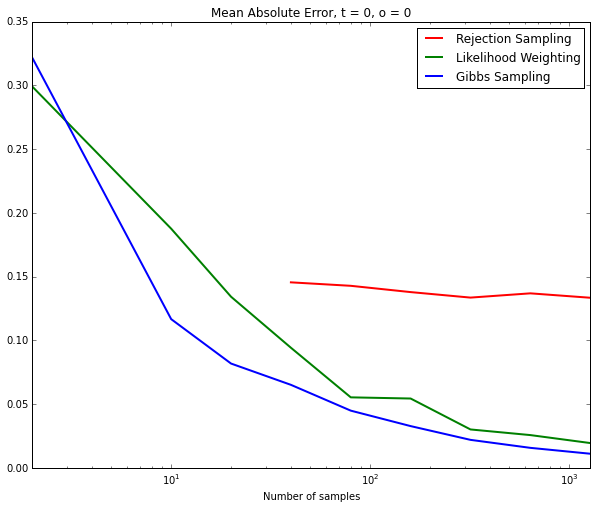

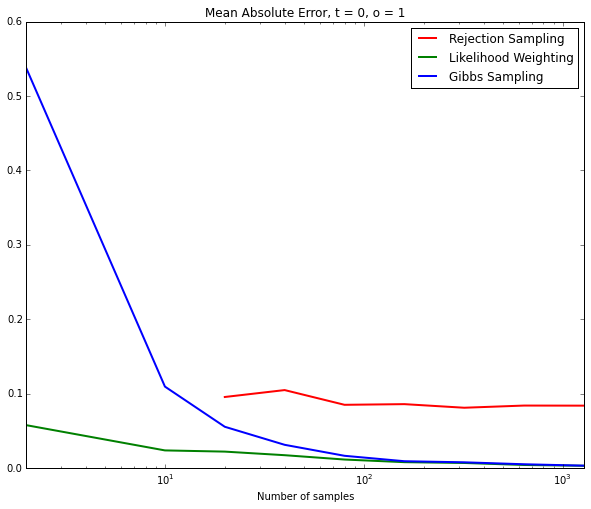

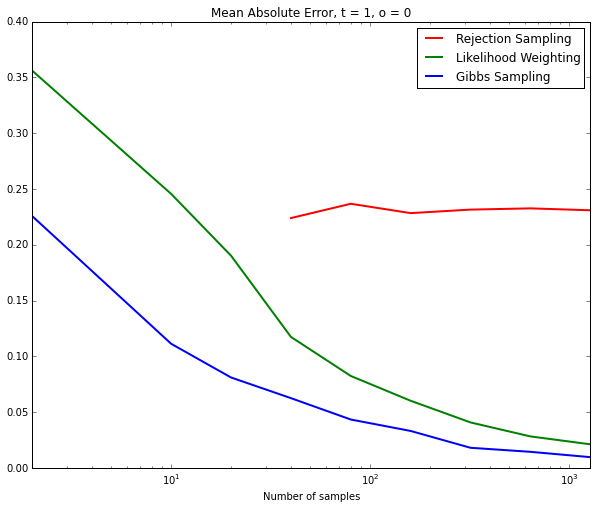

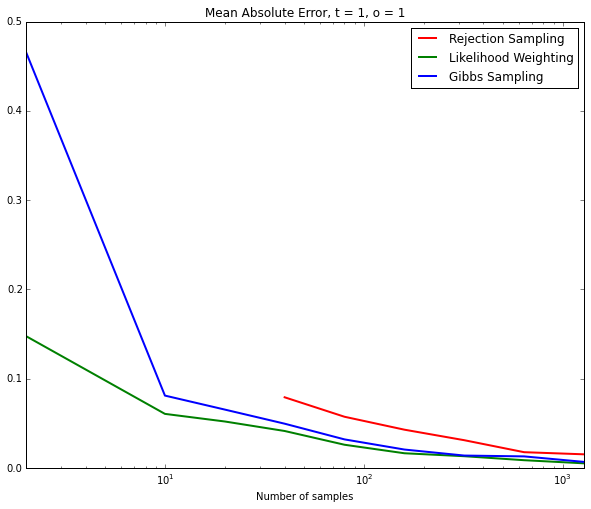

In [151]:
for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    figure(figsize=(10, 8))
    title('Mean Absolute Error, t = %d, o = %d' % (t, o))

    plot(sample_counts, rs_errs[(t, o)], 'r', label='Rejection Sampling', lw=2)
    plot(sample_counts, lw_errs[(t, o)], 'g', label='Likelihood Weighting', lw=2)
    plot(sample_counts, gb_errs[(t, o)], 'b', label='Gibbs Sampling', lw=2)   
    
    legend()
    xscale('log')
    xlim(sample_counts.min(), sample_counts.max())
    xlabel('Number of samples')

In [12]:
approx_rs(0, 0, 10)
approx_lw(0, 0, 10)
approx_gibbs(0, 0, 10)
exact(0,0)

[ 0.4  0.6]


array([ 0.7667407,  0.2332593])